# Audio VQVAE based on Jukebox

In [1]:
import os
import sys
import time
import random
import json
from pathlib import Path
import numpy as np

sys.path.append(os.getcwd())

import torch
from torch.utils.data import DataLoader

import data_load
import plot_utils

from vqvae import VQVAE
from utils.torch_utils import zero_grad, count_parameters, Metrics, get_device

from utils.ema import EMA
from utils.fp16 import FusedAdam, clipped_grad_scale, grad_norm
from hparams import hps, hps_tiny, hps_opt, block_kwargs

## Setup

In [2]:
time_now = time.strftime("%y%m%d-%H%M%S", time.gmtime())
results_dir = Path(os.getcwd()) / f'results-{time_now}'
results_dir.mkdir(parents=True, exist_ok=True)

## Model

In [3]:
model = VQVAE(
    input_shape=(hps.seq_len, 1), down_t=hps.down_t, stride_t=hps.stride_t,
    emb_width=hps.emb_width, l_bins=hps.l_bins, mu=hps.l_mu, commit=hps.commit,
    spectral=hps.spectral, multispectral=hps.multispectral,
    multiplier=hps.hvqvae_multiplier, use_bottleneck=hps.use_bottleneck,
    **block_kwargs)

device, gpu_name = get_device()
model = model.to(device)
print(f'VQVAE model loaded with {count_parameters(model)} params. ' 
      f'Device: {device} {gpu_name}')

VQVAE model loaded with 303489 params. Device: cpu 


## Optimizer

In [4]:
opt = FusedAdam(model.parameters(), lr=hps_opt.lr,
                weight_decay=hps_opt.weight_decay,
                betas=(hps_opt.beta1, hps_opt.beta2), eps=hps_opt.eps)

def lr_lambda(step):
    return (hps_opt.lr_scale * (hps_opt.lr_gamma ** (step // hps_opt.lr_decay))
            * min(1.0, step / hps_opt.lr_warmup))

shd = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda)
ema = EMA(model.parameters(), mu=hps_opt.mu)
forw_kwargs = dict(loss_fn=hps.loss_fn, hps=hps)

## Dataset

In [5]:
test_size = 100
batch_size = 16

data_dir = Path(os.getcwd()).parent / 'samples' / 'nsynth-test'
filenames = list(data_dir.glob('*/*.wav'))
random.shuffle(filenames)

filenames_test = filenames[:test_size]
filenames_train = filenames[test_size:]

ds_test = data_load.Dataset(filenames_test)
ds_train = data_load.Dataset(filenames_train)

## Test

In [6]:
test_generator = torch.utils.data.DataLoader(ds_test, batch_size=batch_size,
                                              shuffle=False, num_workers=0)
def test(samples_to_plot=4):
    model.eval()
    with torch.no_grad():
        losses = []
        for i, x_eval in enumerate(test_generator):
            x_eval = x_eval.unsqueeze(-1).to(device)
            x_recon, loss, _metrics = model(x_eval, **forw_kwargs)
            _metrics['loss'] = loss = loss.item()  # free graph
            losses.append(loss)
            metrics.append_metrics(_metrics, suffix=f' test')
            
            break  # debug
    
    x_eval = x_eval.cpu().detach().numpy()
    x_recon = x_recon.cpu().detach().numpy()

    png_path = results_dir / f'test_pred_e{epoch:03}.png'
    plot_utils.plot_test_pred(x_eval, x_recon, samples_to_plot, epoch=epoch,
                              out_path=png_path)

## Train

In [7]:
train_generator = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=0)
metrics = Metrics()
epochs = 3
for epoch in range(epochs):
    for j, x_train in enumerate(train_generator):
        if j >= 2:
            break
        
        zero_grad(model)
        model.train()
        x_train = x_train.unsqueeze(-1).to(device)
    
        # Forward
        x_out, loss, _metrics = model(x_train, **forw_kwargs)
    
        # Backward
        loss.backward()
        gn = grad_norm(list(model.parameters()), hps_opt.gn_scale)
        opt.step(scale=clipped_grad_scale(gn, hps_opt.clip, hps_opt.gn_scale))
    
        # Metrics
        _metrics['loss'] = loss = loss.item()  # free graph
        _metrics['grad_norm'] = gn
        metrics.append_metrics(_metrics)

        shd.step()
        ema.step()

        # Evaluate
        test()

torch.save(model.state_dict(), results_dir / f'model.pth')

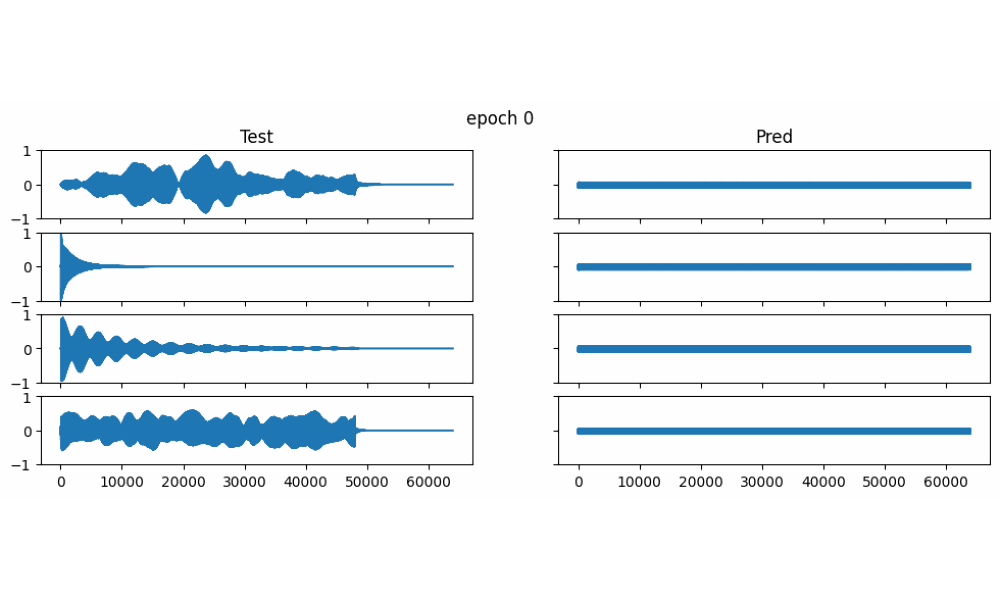

In [14]:
from IPython.display import Image

gif_path = plot_utils.gif_from_pngs(results_dir, prefix='test_pred')
Image(gif_path.read_bytes())